In [3]:
# 01. Setup Inicial e Carregamento de Dados

# Instalar pacotes se necessário:
install.packages(c("caret", "dplyr", "mlbench"))

# Carregar bibliotecas:
library(caret)
library(dplyr)
library(mlbench) # Para o dataset PimaIndiansDiabetes

# Definir semente para reprodutibilidade
set.seed(42)

Warning message:
"os pacotes 'caret', 'dplyr', 'mlbench' estão em uso e não serão instalados"


In [4]:
# 02. Carregamento e Pré-processamento do Dataset

# Carregar o dataset
data(PimaIndiansDiabetes)
df <- PimaIndiansDiabetes

# Inspecionar as primeiras linhas e a estrutura
# head(df)
# str(df)

# Renomear os níveis da variável alvo 'diabetes' para nomes válidos
# 'pos' e 'neg' são frequentemente problemáticos; vamos usar 'Diabete' e 'Nao_Diabete'
df$diabetes <- factor(df$diabetes, 
                      labels = c("Nao_Diabete", "Diabete"))

# Verificar o balanceamento do dataset (importante para classificação)
table(df$diabetes)


Nao_Diabete     Diabete 
        500         268 

In [5]:
# 03. Particionamento e Configuração de Treinamento

# Particionamento Estratificado 70/30
index <- createDataPartition(df$diabetes, p = 0.70, list = FALSE)
train_df <- df[index, ]
test_df <- df[-index, ]

# Configuração de Validação Cruzada Repetida (10-fold, 3 repetições)
control <- trainControl(method = "repeatedcv", 
                        number = 10, 
                        repeats = 3, 
                        summaryFunction = twoClassSummary, # Para classificação binária
                        classProbs = TRUE)                 # Para obter probabilidades

In [6]:
# --- CÉLULA 4: TREINAMENTO DO MODELO DE REGRESSÃO LOGÍSTICA ---

# 1. MODELO PADRÃO (BASELINE) - SEM AJUSTE DE PESO
# Este modelo usa o balanceamento natural do dataset.

message("Treinando Modelo Baseline (Sem Ajuste de Peso)...")

logreg_baseline <- train(
    diabetes ~ ., 
    data = train_df, 
    method = "glm",                 # Regressão Logística (Standard GLM)
    family = "binomial",            # Função de ligação Binomial (para classificação)
    metric = "ROC",                 # Otimiza a AUC (Área Sob a Curva)
    trControl = control, 
    preProcess = c("center", "scale") # Padronização dos dados (Z-score)
)

# ---------------------------------------------------------------

# 2. MODELO OTIMIZADO (MITIGAÇÃO) - COM AJUSTE DE PESO DE CLASSES

# Cálculo dos pesos inversamente proporcionais ao número de observações
# Peso = 1 / (Contagem da Classe)

# Obter contagens de classes no conjunto de treino
class_counts <- table(train_df$diabetes)

# Criar um vetor de pesos (class_weights)
# Para Nao_Diabete: 1 / 350
# Para Diabete: 1 / 150
model_weights <- 1 / class_counts

# Aplicar os pesos calculados no treino
# O parâmetro 'weights' na função glmnet (usada internamente pelo caret) ajusta o custo.

message("Treinando Modelo Otimizado (Com Ajuste de Peso)...")

logreg_otimizado <- train(
    diabetes ~ ., 
    data = train_df, 
    method = "glm", 
    family = "binomial", 
    metric = "ROC", 
    trControl = control,
    preProcess = c("center", "scale"),
    # ATENÇÃO: O 'glm' do caret não tem um parâmetro direto 'class_weights'.
    # Usaremos o parâmetro 'weights' que aplica o peso por observação no GLM.
    weights = ifelse(train_df$diabetes == "Diabete", model_weights["Diabete"], model_weights["Nao_Diabete"])
)


# ---------------------------------------------------------------

# 3. COMPARAÇÃO INICIAL

message("Comparação de Desempenho (Baseline vs. Otimizado):")

print(resamples(list(
    Baseline = logreg_baseline, 
    Otimizado = logreg_otimizado
)) %>% summary())

Treinando Modelo Baseline (Sem Ajuste de Peso)...

Treinando Modelo Otimizado (Com Ajuste de Peso)...

Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message in eval(family$initialize):
"non-integer #successes in a binomial glm!"
Warning message i


Call:
summary.resamples(object = .)

Models: Baseline, Otimizado 
Number of resamples: 30 

ROC 
               Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
Baseline  0.6616541 0.8070175 0.8479114 0.8392119 0.8868421 0.9095238    0
Otimizado 0.7206349 0.7973684 0.8401838 0.8395517 0.8835840 0.9578947    0

Sens 
               Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
Baseline  0.7428571 0.8285714 0.8857143 0.8752381 0.9142857 0.9714286    0
Otimizado 0.6000000 0.7428571 0.7714286 0.7857143 0.8285714 0.9714286    0

Spec 
               Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
Baseline  0.3157895 0.4342105 0.5672515 0.5552632 0.6798246 0.8421053    0
Otimizado 0.5000000 0.6710526 0.7032164 0.7057505 0.7777778 0.8947368    0



[1] "--- Matriz de Confusão (Modelo Otimizado) ---"
Confusion Matrix and Statistics

             Reference
Prediction    Nao_Diabete Diabete
  Nao_Diabete         105      18
  Diabete              45      62
                                          
               Accuracy : 0.7261          
                 95% CI : (0.6636, 0.7826)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : 0.010189        
                                          
                  Kappa : 0.4403          
                                          
 Mcnemar's Test P-Value : 0.001054        
                                          
            Sensitivity : 0.7000          
            Specificity : 0.7750          
         Pos Pred Value : 0.8537          
         Neg Pred Value : 0.5794          
             Prevalence : 0.6522          
         Detection Rate : 0.4565          
   Detection Prevalence : 0.5348          
      Balanced Accuracy : 0.7375          
                

Type 'citation("pROC")' for a citation.


Anexando pacote: 'pROC'


Os seguintes objetos são mascarados por 'package:stats':

    cov, smooth, var


Setting direction: controls < cases



[1] "AUC no Conjunto de Teste: 0.8208"


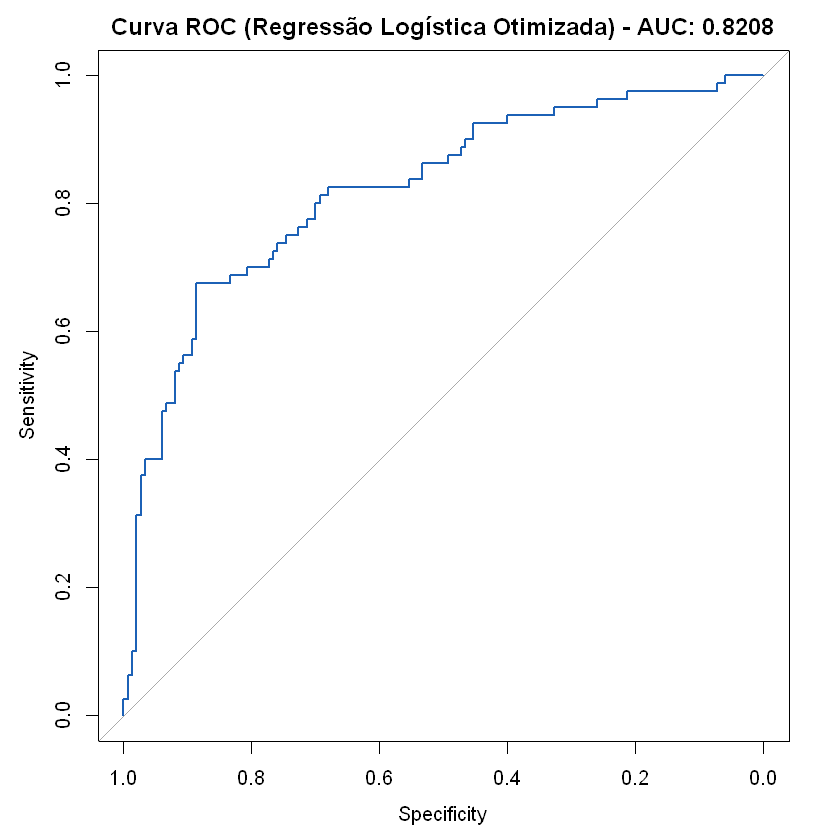

In [7]:
# --- CÉLULA 5: PREVISÃO NO CONJUNTO DE TESTE (MODELO OTIMIZADO) ---

# 1. Fazer Previsões de Classe e Probabilidade
predictions_class <- predict(logreg_otimizado, newdata = test_df)
predictions_prob <- predict(logreg_otimizado, newdata = test_df, type = "prob")

# 2. Gerar a Matriz de Confusão
conf_matrix <- confusionMatrix(predictions_class, test_df$diabetes)

# 3. Exibir a Matriz e Estatísticas
print("--- Matriz de Confusão (Modelo Otimizado) ---")
print(conf_matrix)

# 4. Cálculo da Curva ROC (AUC) para o Conjunto de Teste
library(pROC)
roc_curve <- roc(response = test_df$diabetes, 
                 predictor = predictions_prob$Diabete, 
                 levels = levels(test_df$diabetes))

auc_value <- auc(roc_curve)

print(paste("AUC no Conjunto de Teste:", round(auc_value, 4)))

# 5. Plot da Curva ROC (Visualização da performance do modelo)
plot(roc_curve, 
     main = paste("Curva ROC (Regressão Logística Otimizada) - AUC:", round(auc_value, 4)), 
     col = "#1c61b6", 
     lwd = 2)

# Fim do Modelo